In [1]:
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats

# Porting the code to a notebook, so this is not necessary anymore:
# import argparse

# Using Excel files, so this is not necessary:
# import csv

# New imports
import pandas as pd
import glob
from collections import defaultdict, Counter
from statistics import mean
from matplotlib import pyplot as plt
import seaborn as sns

# Analysing the answers

Here we analyse the answers that the participants provided.

## Answer preference

We start with answer preference. Do participants prefer A or B?

In [2]:
def records_for_dimension(dimension):
    "Create records for a specific dimension to compute Krippendorff's alpha."
    answer_name = {"Coherence": "Answer.best_coh",
                   "Grammaticality": "Answer.best_grammar",
                   "Repetition": "Answer.best_redun"}
    answer = answer_name[dimension]
    frames = []
    for path in glob.glob(f"./Responses/{dimension}/*.xlsx"):
        df = pd.read_excel(path)
        frames.append(df)
    df = pd.concat(frames)
    rows = []
    for record in df.to_records():
        item = record['Input.code']
        response = record[answer].upper()
        rows.append(dict(item=item, response=response))
    return rows

# Here's an alternative that smoothes out the differences between respondents.
# We're not using this because the original authors didn't do this, either.
#
# def records_for_dimension(dimension):
#     "Create records for a specific dimension to compute Krippendorff's alpha."
#     answer_name = {"Coherence": "Answer.best_coh",
#                    "Grammaticality": "Answer.best_grammar",
#                    "Repetition": "Answer.best_redun"}
#     answer = answer_name[dimension]
#     frames = []
#     for path in glob.glob(f"./Responses/{dimension}/*.xlsx"):
#         df = pd.read_excel(path)
#         frames.append(df)
#     df = pd.concat(frames)
#     rating_index = defaultdict(list)
#     for record in df.to_records():
#         item = record['Input.code']
#         response = record[answer]
#         rating_index[item].append(response)
#     rows = []
#     for item, responses in rating_index.items():
#         A = responses.count('A')
#         B = responses.count('B')
#         if A > B:
#             winner = 'A'
#         else:
#             winner = 'B'
#         rows.append(dict(item=item, response=winner))
#     return rows

In [3]:
def get_response_distribution(dimension):
    records = records_for_dimension(dimension)
    c = Counter(d['response'] for d in records)
    return c

counts = []
for dimension in ["Grammaticality", "Repetition", "Coherence"]:
    c = get_response_distribution(dimension)
    counts.append(c)

overall = Counter()
for c in counts:
    overall.update(c)

counts.append(overall)
for c in counts:
    c['Sum'] = sum(c.values())

header = ["Category"] + list(overall.keys())
rows = []
for dimension, c in zip(["Grammaticality", "Repetition", "Coherence", "Total"], counts):
    row = [dimension] + [c[key] for key in overall.keys()]
    rows.append(row)

df = pd.DataFrame(columns=header, data=rows)

with open("./Tables/Answer-frequencies.tex",'w') as f:
    f.write(df.style.hide(axis=0).to_latex(hrules=True))
df

,Category,A,B,5,19,Sum
0,Grammaticality,319,277,4,0,600
1,Repetition,305,287,7,1,600
2,Coherence,320,277,3,0,600
3,Total,944,841,14,1,1800


## System preference

Regardless of the competition, which system was preferred most of the time?

In [4]:
win_percentage = []
for dimension in ["Grammaticality", "Repetition", "Coherence"]:
    records = records_for_dimension(dimension)
    wins = defaultdict(int)
    losses = defaultdict(int)
    for record in records:
        summary, sys1, sys2 = record['item'].split("#")
        sys1 = int(sys1)
        sys2 = int(sys2)
        if record['response'] == 'A':
            wins[sys1] += 1
            losses[sys2] += 1
        elif record['response'] == 'B':
            wins[sys2] += 1
            losses[sys1] += 1

    # Original mapping provided by the authors:
    data_map = {0: 'gold', 1: 'template', 2:'ed_cc' , 3: 'hier', 4: 'macro'}
    df = pd.DataFrame(columns=["System", "Wins", "Losses", "Sum", "Difference"],
                      data=[[system, wins[key], losses[key], wins[key] + losses[key], wins[key] - losses[key]] 
                            for key, system in data_map.items()])
    
    print("-----------------------")
    print(dimension + ":")
    print(df)
    print("-----------------------")
    
    for key, system in data_map.items():
        result = dict(percent_won = (wins[key]/(wins[key] + losses[key])) * 100,
                      system = system,
                      dimension = dimension)
        win_percentage.append(result)

-----------------------
Grammaticality:
     System  Wins  Losses  Sum  Difference
0      gold   130     108  238          22
1  template   140      99  239          41
2     ed_cc    96     143  239         -47
3      hier   108     131  239         -23
4     macro   122     115  237           7
-----------------------
-----------------------
Repetition:
     System  Wins  Losses  Sum  Difference
0      gold   117     121  238          -4
1  template   171      66  237         105
2     ed_cc    88     150  238         -62
3      hier   101     136  237         -35
4     macro   115     119  234          -4
-----------------------
-----------------------
Coherence:
     System  Wins  Losses  Sum  Difference
0      gold   119     120  239          -1
1  template   150      89  239          61
2     ed_cc   102     138  240         -36
3      hier   107     132  239         -25
4     macro   119     118  237           1
-----------------------


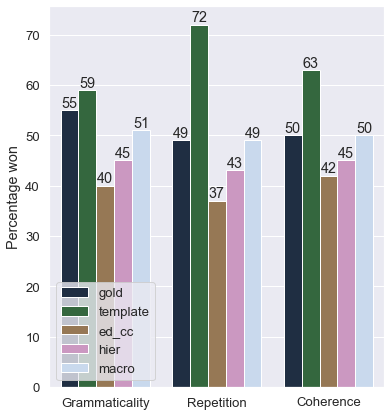

In [5]:
df = pd.DataFrame(win_percentage)
sns.set_style("whitegrid")
sns.set_style(rc = {'axes.facecolor': 'lightsteelblue'})
sns.set(rc={'figure.figsize':(6,7)})
sns.set(font_scale=1.2)
df['percent_won'] = df['percent_won'].apply(round)
ax = sns.barplot(data=df, x='dimension', y='percent_won', hue='system', palette="cubehelix")
plt.legend(loc='lower left')
ax.set(xlabel='', ylabel='Percentage won')
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig("./Figures/won.pdf")

# System performance (mostly original)

Here we analyse system performance using code that is based on what the authors provided to us.

In [6]:
# This function is modified from the "read_file" function provided by the authors.
def create_count_dict(records):
    "Create a dictionary with counts of system wins."
    count_dict = {}
    count_rows = 0
    for row in records:
        input_code = row['item']
        summary_id = input_code.split("#")[0]
        first_system = input_code.split("#")[1]
        second_system = input_code.split("#")[2]
        count_rows += 1
        if summary_id not in count_dict:
            count_dict[summary_id] = {}
        if first_system not in count_dict[summary_id]:
            count_dict[summary_id][first_system] = 0
        if second_system not in count_dict[summary_id]:
            count_dict[summary_id][second_system] = 0
        if row["response"] == "A":
            count_dict[summary_id][first_system] += 1
            count_dict[summary_id][second_system] -= 1
        elif row["response"] == "B":
            count_dict[summary_id][second_system] += 1
            count_dict[summary_id][first_system] -= 1
        else:
            pass
            # assert False
    # Commented out for clearer output:
    print(count_dict)
    print("count_rows", count_rows)
    return count_dict


def process(count_dict):
    data = []
    for key in count_dict:
        # Change wrt the original authors:
        # Added ID 4 here, because there are 4 systems + humans = 5.
        for system_id in [0, 1, 2, 3, 4]:
            data.append((str(system_id), count_dict[key][str(system_id)]))
    data = np.rec.array(data, dtype= [('system', '|U5'), ('Score', '<i8')])
    f, p = stats.f_oneway(data[data['system'] == '0'].Score,
                          data[data['system'] == '1'].Score, 
                          data[data['system'] == '2'].Score,
                          data[data['system'] == '3'].Score,
                          data[data['system'] == '4'].Score)
    print('One-way ANOVA')
    print('=============')

    print('F value:', f)
    print('P value', p, '\n')

    mc = MultiComparison(data['Score'], data['system'])
    result = mc.tukeyhsd()
    print(result)
    print(mc.groupsunique)
    return result


In [7]:
# Original process to call the file:
#
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Significance test for summary comparison')
#     parser.add_argument('-evaluation_type', type=str,
#                         help='type of evaluation', default=None)
#     parser.add_argument('-file_names', '--file_names', nargs='+',
#                         help='input file names', required=True)
#     args = parser.parse_args()
#     count_dict = read_file(args.file_names, args.evaluation_type)
#     process(count_dict)

New code to generate the table in the paper automatically.

In [30]:
def write_count_dict(count_dict, dimension):
    data_map = {0: 'gold', 1: 'template', 2:'ed_cc' , 3: 'hier', 4: 'macro'}
    entries = []
    for summary, scores in count_dict.items():
        for system, score in scores.items():
            entry = dict(system=data_map[int(system)], score=score, summary=summary)
            entries.append(entry)
    df = pd.DataFrame(entries)
    df.to_excel(f"./Responses/ANOVA/{dimension}_anova.xlsx", index=False)


def average_dict(count_dict):
    results = defaultdict(list)
    for counts in count_dict.values():
        for k, v in counts.items():
            results[k].append(v)
    return {int(k):mean(v) for k,v in results.items()}


def get_different_systems(summary):
    """
    Function that takes the summary of the Tukey test and returns
    the systems that significantly differ from system number 4.
    """
    df = pd.DataFrame(columns=summary.data[0], data=summary.data[1:])
    rejected = df.loc[df['group2'] == '4'].loc[df['reject']==True]
    different_systems = rejected['group1'].apply(int).to_list()
    return different_systems

data_map = {0: 'gold', 1: 'template', 2:'ed_cc' , 3: 'hier', 4: 'macro'}
entries = {k:dict() for k in data_map.values()}
for dimension in ["Grammaticality", "Repetition", "Coherence"]:
    print("---------------------------------------------")
    print(dimension)
    records = records_for_dimension(dimension)
    count_dict = create_count_dict(records)
    write_count_dict(count_dict, dimension)
    tukey_result = process(count_dict)
    summary = tukey_result.summary()
    mean_scores = average_dict(count_dict)
    print(mean_scores)
    different_systems = get_different_systems(summary)
    for system, name in data_map.items():
        sig = '*' if system in different_systems else ''
        score = f"{((mean_scores[system]/12)*100):.2f}"
        entries[name][dimension] = score+sig

results_table = pd.DataFrame(entries).T

---------------------------------------------
Grammaticality
{'577': {'1': 4, '0': -6, '2': 6, '3': 0, '4': -4}, '172': {'1': 0, '0': 0, '2': 4, '3': -8, '4': 4}, '394': {'1': 4, '0': 2, '2': 0, '3': -8, '4': 2}, '259': {'1': 6, '0': -2, '2': -4, '3': 2, '4': -2}, '643': {'1': -2, '0': 8, '2': -2, '3': -2, '4': -2}, '717': {'0': 8, '1': 0, '2': -6, '3': -4, '4': 2}, '87': {'0': 4, '1': 2, '2': 4, '3': -6, '4': -4}, '666': {'0': 2, '1': 2, '2': -6, '3': 4, '4': -2}, '534': {'1': 2, '0': 2, '2': 0, '3': 2, '4': -6}, '447': {'0': -6, '1': 8, '2': -2, '3': 0, '4': 0}, '204': {'1': 4, '3': 2, '0': -2, '4': 4, '2': -8}, '55': {'3': -2, '2': -2, '0': 0, '1': 0, '4': 4}, '606': {'3': -2, '0': 6, '1': -4, '2': -2, '4': 2}, '654': {'2': -4, '4': 4, '1': -4, '0': 0, '3': 4}, '538': {'1': 2, '4': 2, '0': 2, '2': -6, '3': 0}, '256': {'1': 0, '0': -2, '2': -2, '3': 0, '4': 4}, '126': {'0': 3, '1': 8, '2': -4, '3': 0, '4': -7}, '390': {'0': -4, '1': 0, '2': 0, '3': -7, '4': 11}, '418': {'0': 5, '1': 

In [27]:
with open("./Tables/results_table.tex",'w') as f:
    f.write(results_table.style.to_latex(hrules=True))
results_table

,Grammaticality,Repetition,Coherence
gold,9.17,-1.67,-0.42
template,17.08,43.75*,25.42
ed_cc,-19.58,-25.83,-15.00
hier,-9.58,-14.58,-10.42
macro,2.92,-1.67,0.42


In [ ]:
# TODO: all statistics to LaTeX.